# Dependencies

In [1]:
import glob
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

warnings.filterwarnings("ignore")

# Download data

In [2]:
!wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

--2022-01-15 23:27:41--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/goemotions_1.csv.2’

goemotions_1.csv.2  100%[===================>]  13.52M  --.-KB/s    in 0.1s    

2022-01-15 23:27:41 (136 MB/s) - ‘data/goemotions_1.csv.2’ saved [14174600/14174600]

--2022-01-15 23:27:41--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.203.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

# Load data

In [3]:
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 
          'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 
          'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
          'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
          'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 
          'neutral']

path_list = glob.glob("data/goemotions_*.csv", recursive=True)
dfs = [pd.read_csv(path, usecols=(['text'] + labels)) for path in path_list]
dataset = pd.concat(dfs)
# Shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)

print(f"Number of samples: {len(dataset)}")
print(f"Number of labels: {len(labels)}")
display(dataset.head())

Number of samples: 211225
Number of labels: 28


,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,some men sit to pee. men also get attacked and...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,All I've said about that topic is that I suppo...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Lol, no.",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Are you here to solve my catsup problem?,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,It wasn't about your syllable count. It was ab...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Preprocessing

For now the only preprocessing that we are going to do is lower casing all text and drop samples without text.

We can apply our preprocessing steps to our text feature in the dataframe by wrapping all these processes under a function.

In [4]:
dataset.dropna(subset=["text"], axis=0, inplace=True)
print(f"Number of samples: {len(dataset)}")

Number of samples: 211225


In [5]:
# Define preprocessing function
def preprocess(text, lower=True):
    if lower:
        text = text.lower()
    return text

In [6]:
# Apply to dataframe
dataset.text = dataset.text.apply(preprocess, lower=True)

# EDA

## Positive labels per text sample

**Question:** How many positive labels do each sample have on average? This might give an idea if samples have too many singals or not (many labels for each sample).

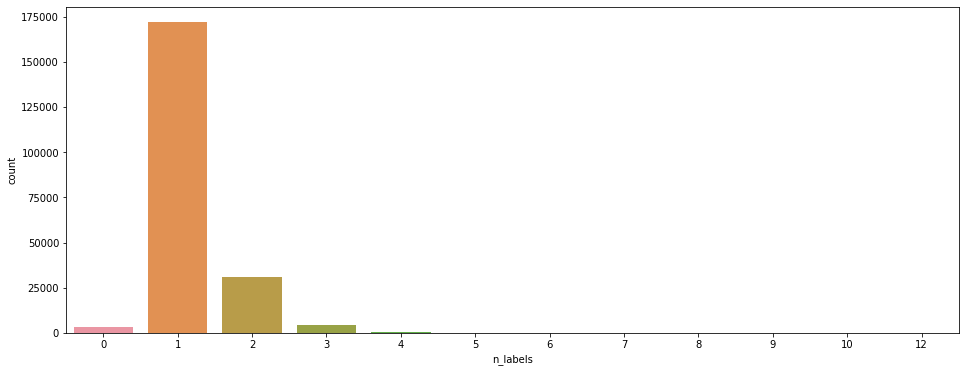

In [7]:
dataset['n_labels'] = dataset[labels].sum(axis=1)

plt.figure(figsize=(16, 6))
sns.countplot(x="n_labels", data=dataset)
plt.show()

## Label distribution

**Question:** How many samples do we have for each label? Which ones are more popular and wich ones migh have too few samples?

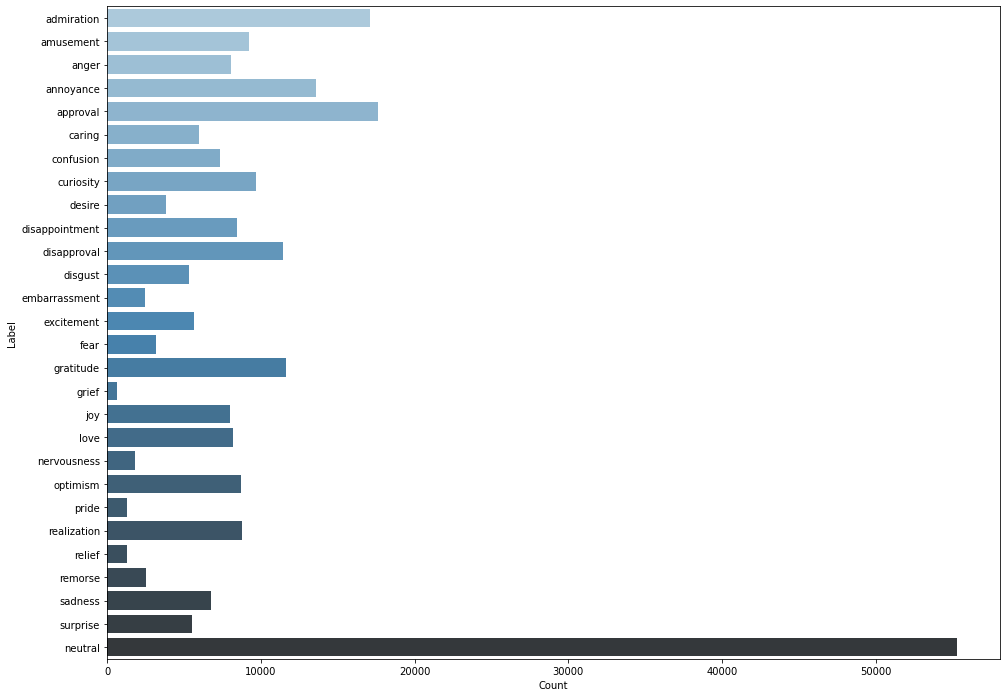

In [8]:
label_count = dataset[labels].agg({x:'sum' for x in labels}).reset_index()
label_count.columns = ['Label', 'Count']

plt.figure(figsize=(16, 12))
sns.barplot(x="Count", y="Label", data=label_count, palette="Blues_d")
plt.show()

## Text length

**Question:** How is distributed the size of our text samples? This could give us some insights if some samples might need to be truncated or if some of them are too small to have enought context.

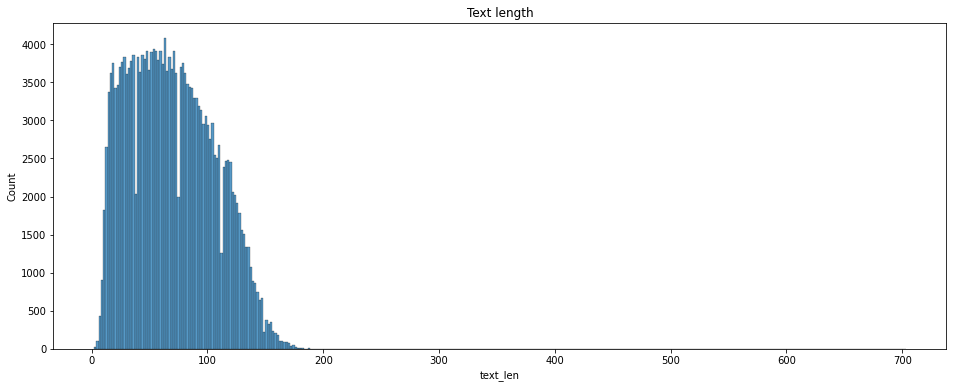

In [9]:
dataset["text_len"] = dataset["text"].apply(lambda x : len(x))

plt.figure(figsize=(16, 6))
sns.histplot(dataset['text_len']).set_title('Text length')
plt.show()

## Wordcloud

**Question:**  Is there enough signal in the text that is related to the label?

### Wordcloud for "gratitude"

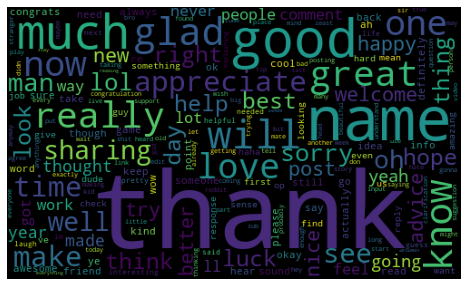

In [10]:
def display_word_cloud(df, label):
    plt.figure(figsize=(15, 5))
    subset = df[df[label] == 1]
    text = subset.text.values
    cloud = WordCloud(stopwords=STOPWORDS, background_color="black", 
                      collocations=False, width=500, 
                      height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

display_word_cloud(dataset, label="gratitude")

### Wordcloud for "sadness"

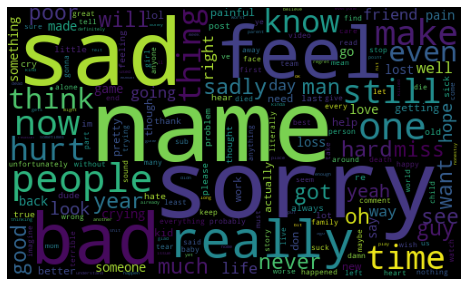

In [11]:
display_word_cloud(dataset, label="sadness")

# Dataset split

- Train (70%): 147857
- Validation (15%): 31684
- Test (15%): 31684

In [12]:
from sklearn.model_selection import train_test_split
seed = 42

In [13]:
X_train, X_test, y_train, y_test = train_test_split(dataset.text, dataset[labels], test_size=0.5, random_state=seed)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

In [14]:
train_df = y_train.copy()
train_df["text"] = X_train
print(f"Train samples: {len(train_df)}")

valid_df = y_valid.copy()
valid_df["text"] = X_valid
print(f"Validation samples: {len(valid_df)}")

test_df = y_test.copy()
test_df["text"] = X_test
print(f"Test samples: {len(test_df)}")

Train samples: 105612
Validation samples: 52807
Test samples: 52806


In [15]:
# Save dataset
train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/valid.csv", index=False)
train_df.to_csv("data/test.csv", index=False)

## Data distribution

### Complete dataset

Number of samples: 211225


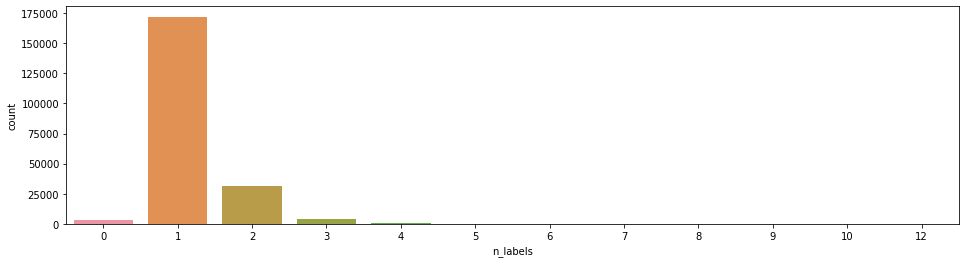

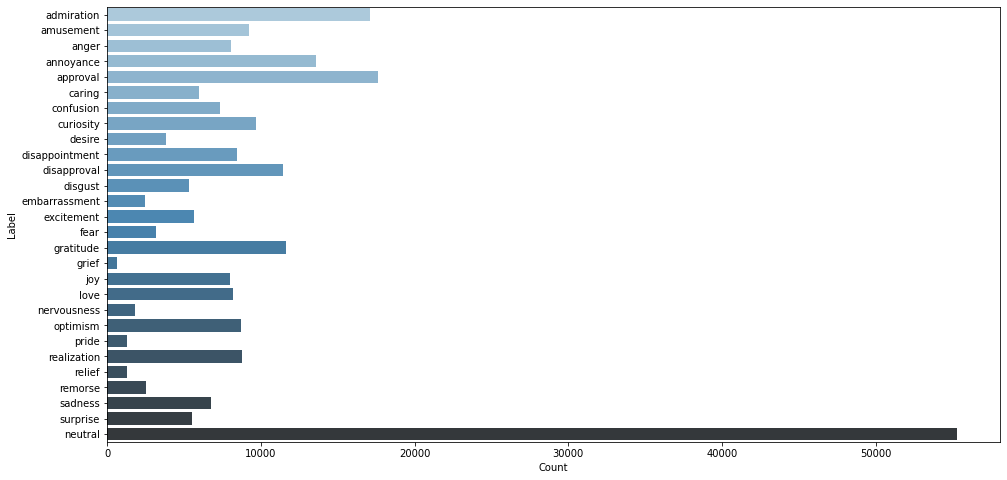

In [16]:
print(f"Number of samples: {len(dataset)}")

dataset['n_labels'] = dataset[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=dataset)
plt.show()

label_count = dataset[labels].agg({x:'sum' for x in labels}).reset_index()
label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=label_count, palette="Blues_d")
plt.show()

### Train dataset

Number of samples: 105612


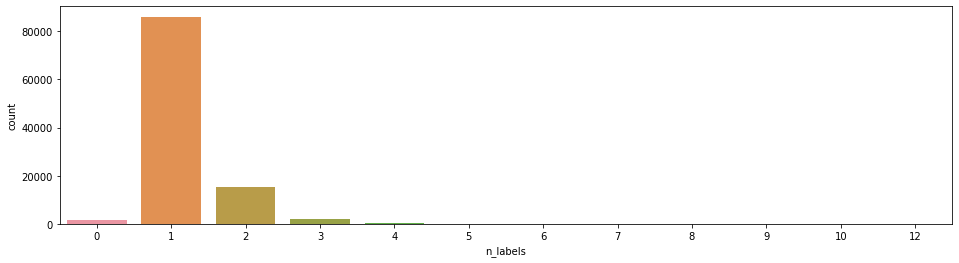

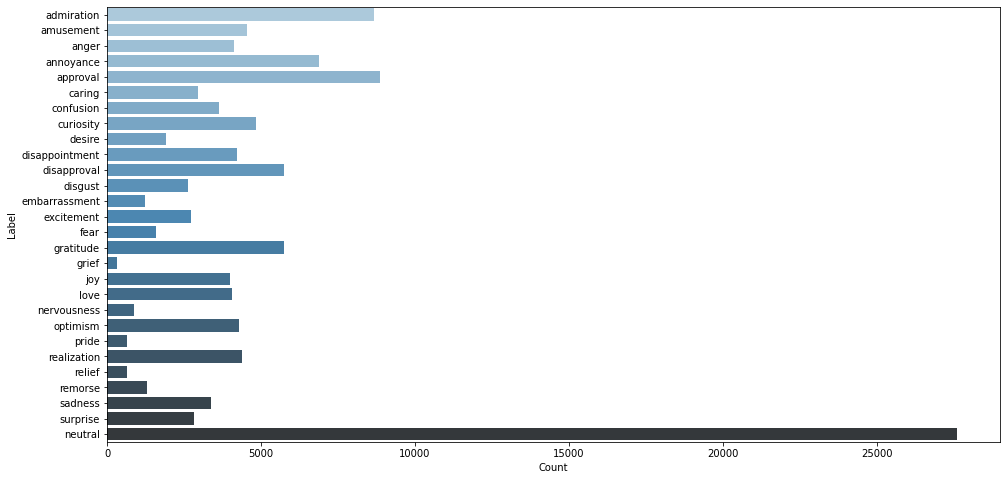

In [17]:
print(f"Number of samples: {len(train_df)}")

train_df['n_labels'] = train_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=train_df)
plt.show()

train_label_count = train_df[labels].agg({x:'sum' for x in labels}).reset_index()
train_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=train_label_count, palette="Blues_d")
plt.show()

### Validation dataset

Number of samples: 52807


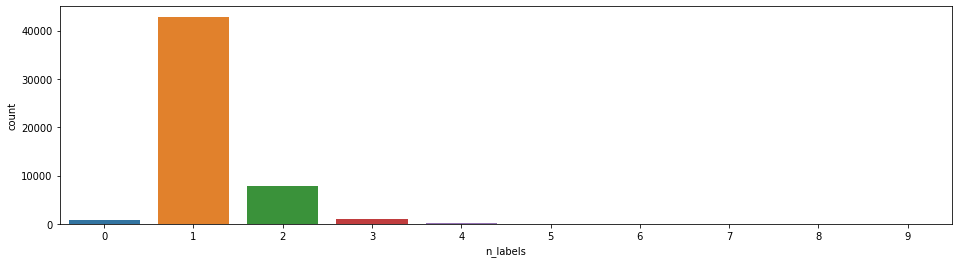

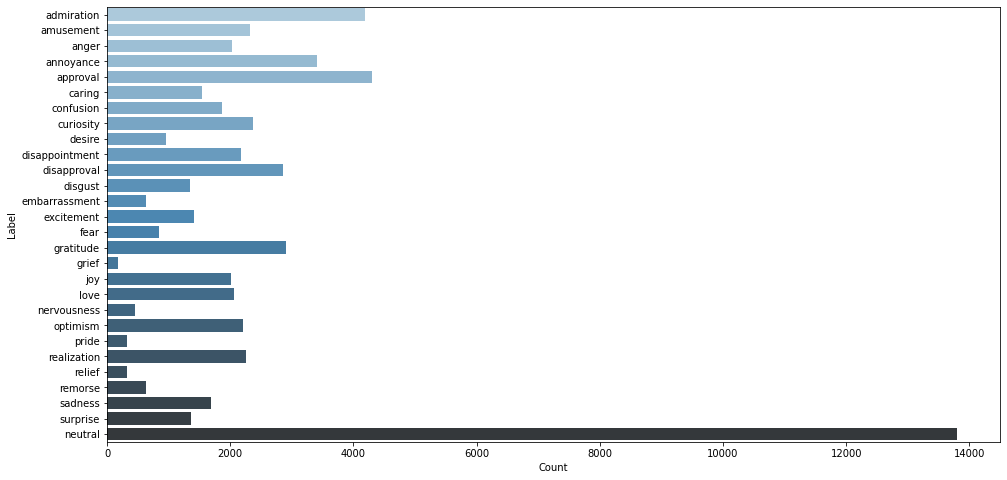

In [18]:
print(f"Number of samples: {len(valid_df)}")

valid_df['n_labels'] = valid_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=valid_df)
plt.show()

valid_label_count = valid_df[labels].agg({x:'sum' for x in labels}).reset_index()
valid_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=valid_label_count, palette="Blues_d")
plt.show()

### Test dataset

Number of samples: 52806


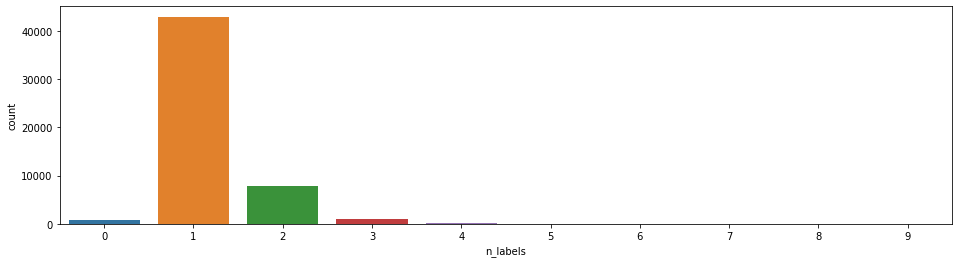

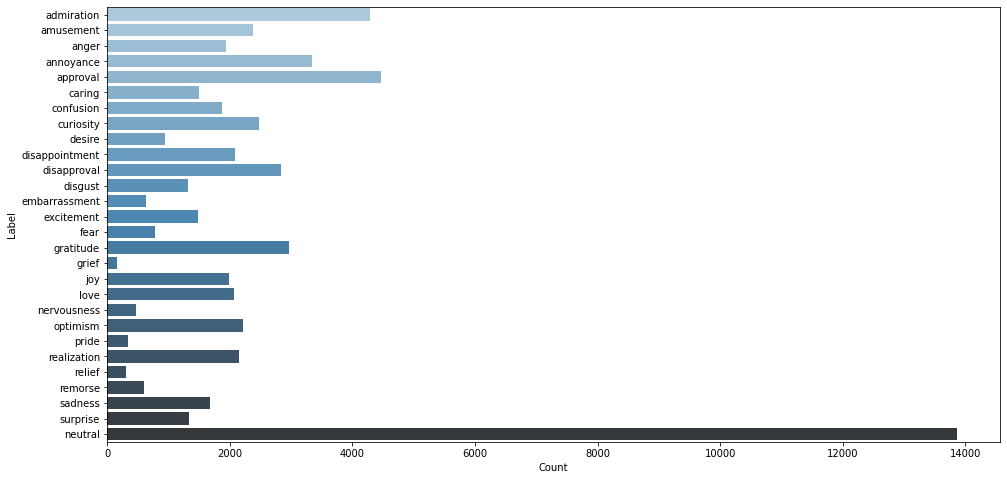

In [19]:
print(f"Number of samples: {len(test_df)}")

test_df['n_labels'] = test_df[labels].sum(axis=1)
plt.figure(figsize=(16, 4))
sns.countplot(x="n_labels", data=test_df)
plt.show()

test_label_count = test_df[labels].agg({x:'sum' for x in labels}).reset_index()
test_label_count.columns = ['Label', 'Count']
plt.figure(figsize=(16, 8))
sns.barplot(x="Count", y="Label", data=test_label_count, palette="Blues_d")
plt.show()

# Modeling

In [20]:
import random, os, json
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Random

motivation: We want to know what random (chance) performance looks like. All of our subsequent baselines should perform better than this.

In [21]:
# Set seeds
set_seeds(seed)

In [22]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=2, size=(len(test_df), len(labels)))
print(y_pred.shape)
print(y_pred[:5])

(52806, 28)
[[0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1]
 [1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1]
 [0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0]
 [1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0]]


### Evaluation

In [23]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.09438879691305894,
  "recall": 0.5006079805446225,
  "f1": 0.1419068636323539
}


We made the assumption that there is an equal probability for whether an input has an emotion or not but this isn't true. Let's use the train split to figure out what the true probability is.



In [24]:
# Percentage of 1s (tag presence)
tag_p = np.sum(np.sum(y_train)) / (len(y_train) * len(labels))
print(tag_p)

0.042145508356734356


In [25]:
# Generate weighted random predictions
y_pred = np.random.choice(
    np.arange(0, 2), size=(len(y_test), len(labels)),
    p=[1-tag_p, tag_p])

In [26]:
# Validate percentage
np.sum(np.sum(y_pred)) / (len(y_pred) * len(labels))

0.04231256188420147

### Evaluation

In [27]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.09326757224968778,
  "recall": 0.042158650923170456,
  "f1": 0.048700157846792616
}


**limitations:** we didn't use any of the signals from our inputs to affect our predictions, so nothing was learned.



## Rule-based

motivation: we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

### Top-K words

Usually in texts, emotions are heavily correlated with the occurences of a few words that gives drives the main emotion of that text, sometimes that words can be the emotions themselves, let's try to predict the labels looking if a piece of text contains words that are commonly found in other texts with the same emotions.

**Domain knowledge**: This dataset has anonimyzed names, so instead of a person's name we have `[name]` instead, this adds no value to our predictions, so lets also remove this from the top-K words

In [28]:
from pprint import pprint
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop.append("[name]")
stop.append("[name].")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
def get_top_k_words(dataset, k=15, label="love"):
    label_text = dataset[dataset[label] == 1].text
    clean_text = label_text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    top_k_words = pd.Series(' '.join(clean_text).split()).value_counts().index[:k]
    return list(top_k_words)

In [30]:
# Top-15 words for "grief"
print(get_top_k_words(train_df, k=15, label="grief"))

['died', 'sorry', "i'm", 'like', 'people', 'years', 'death', 'one', 'dead', 'feel', 'still', 'rip', 'get', 'lost', 'bad']


In [31]:
# Top-15 words for "love"
print(get_top_k_words(train_df, k=15, label="love"))

['love', 'like', 'would', 'it.', 'one', 'really', 'loved', "i'm", 'favorite', 'get', 'people', 'see', 'much', 'good', 'loves']


In [32]:
# Create a dict with top-K words for each label
def get_top_words_dict(dataset, labels=labels, k=15):
    return {label:get_top_k_words(train_df, k=k, label=label) for label in labels}

In [33]:
top_words_dict = get_top_words_dict(train_df)
pprint(top_words_dict)

{'admiration': ['good',
                'great',
                'like',
                'love',
                'really',
                "that's",
                'pretty',
                'one',
                'best',
                'nice',
                'would',
                "i'm",
                'get',
                'looks',
                'amazing'],
 'amusement': ['lol',
               'like',
               'lol.',
               'haha',
               'funny',
               'fun',
               "i'm",
               'love',
               'one',
               'lmao',
               'good',
               'people',
               'would',
               'get',
               'got'],
 'anger': ['fuck',
           'hate',
           'fucking',
           'like',
           'people',
           'get',
           'would',
           "i'm",
           'one',
           'damn',
           'go',
           'hell',
           'stupid',
           'even',
           'reall

Some words are too common and appear in many different labels, let's remove those words that appear in at least 20% of the total labels.

In [34]:
from collections import Counter

label_words = []
for words in top_words_dict.values():
    label_words.extend(words)

label_counts = Counter(label_words)
print(label_counts)

Counter({'like': 28, "i'm": 28, 'get': 26, 'really': 24, 'one': 24, 'would': 24, 'people': 19, 'know': 13, 'good': 12, 'even': 12, 'i’m': 12, 'think': 10, 'love': 8, "that's": 8, 'it.': 8, 'see': 8, 'feel': 7, 'still': 7, 'bad': 6, 'got': 5, 'never': 5, 'oh': 5, 'hope': 4, 'sorry': 4, 'glad': 4, 'go': 3, 'don’t': 3, 'you.': 3, 'great': 2, 'fun': 2, 'hate': 2, 'fucking': 2, 'it’s': 2, 'need': 2, 'better': 2, 'want': 2, 'wish': 2, 'could': 2, 'weird': 2, 'happy': 2, 'worried': 2, 'thank': 2, 'much': 2, 'pretty': 1, 'best': 1, 'nice': 1, 'looks': 1, 'amazing': 1, 'lol': 1, 'lol.': 1, 'haha': 1, 'funny': 1, 'lmao': 1, 'fuck': 1, 'damn': 1, 'hell': 1, 'stupid': 1, 'right': 1, 'take': 1, 'sure': 1, 'maybe': 1, 'understand': 1, 'curious': 1, '[name]?': 1, 'make': 1, 'wanted': 1, "can't": 1, 'worst': 1, 'disgusting': 1, 'disgusting.': 1, 'shame': 1, 'excited': 1, 'new': 1, 'scared': 1, 'afraid': 1, 'terrible': 1, 'horrible': 1, 'scary': 1, 'thanks': 1, 'you!': 1, 'thanks!': 1, ':)': 1, 'apprec

In [35]:
words_to_remove = []
for word, cnt in label_counts.items():
    if cnt >= (len(labels) * 0.4):
      words_to_remove.append(word)
print(words_to_remove)

['good', 'like', 'really', 'one', 'would', "i'm", 'get', 'people', 'even', 'know', 'i’m']


In [36]:
for key, value in top_words_dict.items():
    top_words_dict[key] = [word for word in value if word not in words_to_remove]
pprint(top_words_dict)

{'admiration': ['great',
                'love',
                "that's",
                'pretty',
                'best',
                'nice',
                'looks',
                'amazing'],
 'amusement': ['lol', 'lol.', 'haha', 'funny', 'fun', 'love', 'lmao', 'got'],
 'anger': ['fuck', 'hate', 'fucking', 'damn', 'go', 'hell', 'stupid'],
 'annoyance': ['think', 'it’s', "that's", 'fucking', 'don’t', 'it.'],
 'approval': ['think', "that's", 'it.', 'see', 'love', 'right'],
 'caring': ['feel',
            'hope',
            'go',
            'love',
            'you.',
            'need',
            'better',
            'take',
            'it.'],
 'confusion': ['think', 'sure', 'don’t', 'maybe', 'understand'],
 'curiosity': ['think', 'see', 'curious', 'want', '[name]?'],
 'desire': ['wish',
            'want',
            'hope',
            'could',
            'see',
            'love',
            'need',
            'make',
            'wanted'],
 'disappointment': ['bad

In [37]:
# Prediction
def predict_top_k(input, labels=labels, labels_dict=top_words_dict):
    y_pred = []
    for text in input:
        preds = []
        for label in labels:
            if any(word in text.split() for word in labels_dict[label]):
                preds.append(1)
            else:
                preds.append(0)
        y_pred.append(preds)
    return y_pred

y_pred = predict_top_k(X_test)

### Evaluation

In [38]:
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print(json.dumps(performance, indent=2))

{
  "precision": 0.17238363269415924,
  "recall": 0.27794310582061377,
  "f1": 0.19006929783298798
}


### Inference

In [39]:
def inference_top_k(input, labels=labels, labels_dict=top_words_dict):
    preds = {}
    for label in labels:
        if any(word in input.split() for word in labels_dict[label]):
            preds[label] = 1
        else:
            preds[label] = 0
    return preds

text = "I am loving this amazing MLOps tutorial, so much cool content"
pprint(inference_top_k(text))

{'admiration': 1,
 'amusement': 0,
 'anger': 0,
 'annoyance': 0,
 'approval': 0,
 'caring': 0,
 'confusion': 0,
 'curiosity': 0,
 'desire': 0,
 'disappointment': 0,
 'disapproval': 0,
 'disgust': 0,
 'embarrassment': 0,
 'excitement': 0,
 'fear': 0,
 'gratitude': 1,
 'grief': 0,
 'joy': 0,
 'love': 1,
 'nervousness': 0,
 'neutral': 0,
 'optimism': 0,
 'pride': 0,
 'realization': 0,
 'relief': 1,
 'remorse': 0,
 'sadness': 0,
 'surprise': 0}


**limitations:** we failed to generalize or learn any implicit patterns to predict the labels because we are trying to predict by using the words themselves, and we do not capture text context or intention, where most of the emotion would be captured.

> We could further improve this approach by using more preprocessing like removing punctuation or using top-k words that are more unique for each label, applying maybe normalization similar to TF-IDF.

## Simple ML

**motivation:**
- **representation:** use term frequency-inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.
- **architecture:** we want our model to meaningfully extract the encoded signal to predict the output labels.

So far we've treated the words in our input text as isolated tokens and we haven't really captured any meaning between tokens. Let's use term frequency–inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs.

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [41]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [46]:
# Tf-idf
vectorizer = TfidfVectorizer()
print(X_train.iloc[0])
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf = vectorizer.transform(X_test)
print(X_train_tfidf.shape)
print(X_train_tfidf[0]) # scipy.sparse.csr_matrix

> get used to it, the cons are back. i just wish that they were pros instead of cons
(105612, 29256)
  (0, 17905)	0.10093192940050902
  (0, 13563)	0.23244141753234374
  (0, 20227)	0.346543409680078
  (0, 28363)	0.18182678412482414
  (0, 25898)	0.1283896096821365
  (0, 25824)	0.09077964647579208
  (0, 28649)	0.20201077086832173
  (0, 14226)	0.12364951953061684
  (0, 2453)	0.1776786308568916
  (0, 1907)	0.1269795849423059
  (0, 5844)	0.7522349481234951
  (0, 25831)	0.07394621361956884
  (0, 13895)	0.08874629356430064
  (0, 26209)	0.08340138849971308
  (0, 27510)	0.21632213147734378
  (0, 11092)	0.14547197728531017


In [47]:
def fit_and_evaluate(model):
    """Fit and evaluate each model."""
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [48]:
  # Models
performance = {}
performance["logistic-regression"] = fit_and_evaluate(OneVsRestClassifier(
    LogisticRegression(), n_jobs=1))

performance["support-vector-machine"] = fit_and_evaluate(OneVsRestClassifier(
    LinearSVC(), n_jobs=-1))

print(json.dumps(performance, indent=2))

92.58448243141174
22.51758050918579
{
  "logistic-regression": {
    "precision": 0.5670655922306883,
    "recall": 0.13277975104796647,
    "f1": 0.19318547739136355
  },
  "support-vector-machine": {
    "precision": 0.49140157008350843,
    "recall": 0.19756167802630314,
    "f1": 0.2643629914830855
  }
}


**limitations:**

- **representation:** TF-IDF representations don't encapsulate much signal beyond frequency but we require more fine-grained token representations.
- **architecture:** we want to develop models that can use better represented encodings in a more contextual manner